# Personalised Praise: Productivity on Spanish Wikipedia

We do a similar analysis of productivity on Spanish Wikipedia as we did for retention. First, we do a post-deployment comparison of the control group and Mentorship with Personalised Praise. Secondly, we do a DiD analysis of pre/post deployment to see if Mentorship with Personalised Praise behaves differently than Mentorship without Personalised Praise.

## Findings

We find that Mentorship with Personalised Praise increases the number of edits made, both when comparing it against the control group that did not have access to a mentor, and when comparing it against the period prior to deployment.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'personalised_praise_eswiki_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffiiiiiiiii'

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        platform_name = factor(ifelse(platform == 'desktop', 'Desktop', 'Mobile web')),
        has_mentor = factor(ifelse(mentor_enabled == 1, 'Yes', 'No')),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_30d = num_article_edits_30d + num_other_edits_30d,
        num_total_edits = num_total_edits_24hrs + num_total_edits_30d,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_30d,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_30d,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_30d = num_article_reverts_30d + num_other_reverts_30d,
        num_total_reverts = num_reverts_24hrs + num_reverts_30d,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_30d > 0),
        is_retained_other = is_activated_other & (num_other_edits_30d > 0),
        is_retained = is_activated & ((num_article_edits_30d + num_other_edits_30d) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_30d - num_article_reverts_30d) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_30d - num_other_reverts_30d) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_30d + num_other_edits_30d -
              num_article_reverts_30d - num_other_reverts_30d) > 0)
    ) 
}

In [5]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [6]:
nrow(editing_data)

[1] 113482

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [9]:
editing_data %>%
    group_by(wiki_db, platform_name, exp_group, has_mentor) %>%
    summarize(n = n())

`summarise()` has grouped output by 'wiki_db', 'platform_name', 'exp_group'.
You can override using the `.groups` argument.


wiki_db platform_name exp_group           has_mentor n    
1 eswiki  Desktop       control             No         11355
2 eswiki  Desktop       control             Yes         2022
3 eswiki  Desktop       personalised_praise No         26764
4 eswiki  Desktop       personalised_praise Yes        23134
5 eswiki  Mobile web    control             No          9437
6 eswiki  Mobile web    control             Yes         1739
7 eswiki  Mobile web    personalised_praise No         20812
8 eswiki  Mobile web    personalised_praise Yes        18219

# Productivity Summary

In [ ]:
editing_data |>
    mutate(
        num_const_article_edits = num_article_edits_24hrs + num_article_edits_30d -
               num_article_reverts_24hrs - num_article_reverts_30d
    ) |>
    group_by(wiki_db, platform_name, exp_group, has_mentor) |>
    summarize(mean_total_edits = mean(num_total_edits), median_total_edits = median(num_total_edits),
              mean_constr_article_edits = mean(num_const_article_edits),
              median_constr_article_edits = median(num_const_article_edits),
              q75_constr_article_edits = quantile(num_const_article_edits, 0.75),
              q90_constr_article_edits = quantile(num_const_article_edits, 0.9),
              q95_constr_article_edits = quantile(num_const_article_edits, 0.95),
              geomean_constr_article_edits = mean(exp(log(1 + num_const_article_edits))) - 1
             )

# Regression models

We start by investigating overall producitivty for the Personalised Praise period. In this case, we define the period as after *full* deployment, meaning we filter out all registrations prior to 2023-05-25.

## Overall productivity

In [11]:
blas_set_num_threads(16)
overall.productivity.model.1 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [12]:
summary(overall.productivity.model.1)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    platform, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.418  -0.417  -0.415  -0.209 250.506 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      0.70010    0.01928   36.31 < 0.0000000000000002 ***
platformdesktop  0.11011    0.02143    5.14           0.00000028 ***
has_mentorYes    0.06422    0.02125    3.02               0.0025 ** 
Log(theta)      -1.66832    0.00901 -185.19 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
                Estimate Std. Error z value Pr(>|z|)
(Intercept)       -13.91      32.32   -0.43     0.67
platformdesktop    -2.43     109.30   -0.02     0.98
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 



In [13]:
blas_set_num_threads(16)
overall.productivity.model.2 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [14]:
summary(overall.productivity.model.2)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    1, data = filter(editing_data, date(user_registration_ts) > as.Date("2023-05-25")), 
    dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.418  -0.417  -0.415  -0.209 250.498 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      0.70014    0.01928   36.31 < 0.0000000000000002 ***
platformdesktop  0.11010    0.02143    5.14           0.00000028 ***
has_mentorYes    0.06418    0.02125    3.02               0.0025 ** 
Log(theta)      -1.66831    0.00901 -185.19 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -11.67       7.27    -1.6     0.11
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.189 
Number of iterations in BFGS optimization: 25 
Log-li

In [17]:
blas_set_num_threads(16)
overall.productivity.model.3 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    MASS::glm.nb(
        formula = num_total_edits ~ platform + has_mentor
    )
blas_set_num_threads(1)

In [18]:
summary(overall.productivity.model.3)


Call:
MASS::glm.nb(formula = num_total_edits ~ platform + has_mentor, 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")), init.theta = 0.1885642562, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.994  -0.982  -0.963  -0.257  14.666  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       0.7001     0.0193   36.23 < 0.0000000000000002 ***
platformdesktop   0.1101     0.0214    5.14           0.00000028 ***
has_mentorYes     0.0642     0.0212    3.02               0.0025 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.189) family taken to be 1)

    Null deviance: 39635  on 50988  degrees of freedom
Residual deviance: 39600  on 50986  degrees of freedom
AIC: 163088

Number of Fisher Scoring iterations: 1


              Theta:  0.18856 
          Std. Err.:  0.00170 

 2 x log-likelihood:  -163079.6

In [19]:
modelsummary::get_gof(overall.productivity.model.1)

aic    bic    r.squared adj.r.squared rmse nobs 
1 163092 163145 0.00249   0.00243       14.7 50989

In [20]:
modelsummary::get_gof(overall.productivity.model.2)

aic    bic    r.squared adj.r.squared rmse nobs 
1 163090 163134 0.00249   0.00243       14.7 50989

In [21]:
modelsummary::get_gof(overall.productivity.model.3)

aic    bic    r2.nagelkerke rmse nobs  logLik
1 163088 163123 0.00129       14.7 50989 -81540

Why are these $r^2$ values so low?

In [ ]:
editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    ggplot(aes(x = log2(1 + num_total_edits))) +
    geom_histogram(colour="black", fill='white') +
    labs(
        title = 'Total number of edits',
        subtitle = 'Spanish Wikipedia'
      )

In [ ]:
editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    mutate(user_reg_date = date(user_registration_ts)) |>
    group_by(user_reg_date, has_mentor) |>
    summarise(n = n()) |>
    ggplot(aes(x = user_reg_date, y = n, colour = has_mentor)) +
    geom_line()

In [25]:
blas_set_num_threads(16)
overall.productivity.model.4 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'poisson',
        link = 'logit')
blas_set_num_threads(1)

In [26]:
summary(overall.productivity.model.4)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    1, data = filter(editing_data, date(user_registration_ts) > as.Date("2023-05-25")), 
    dist = "poisson", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.731  -0.730  -0.721  -0.374 421.397 

Count model coefficients (poisson with log link):
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      1.62463    0.00568  286.25 <0.0000000000000002 ***
platformdesktop  0.09648    0.00613   15.74 <0.0000000000000002 ***
has_mentorYes    0.01609    0.00603    2.67              0.0076 ** 

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value            Pr(>|z|)    
(Intercept)  0.36539    0.00904    40.4 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 17 
Log-likelihood: -2.15e+05 on 4 Df

In [27]:
blas_set_num_threads(16)
overall.productivity.model.5 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | platform,
        dist = 'poisson',
        link = 'logit')
blas_set_num_threads(1)

In [28]:
summary(overall.productivity.model.5)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    platform, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), dist = "poisson", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.735  -0.733  -0.717  -0.369 422.209 

Count model coefficients (poisson with log link):
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      1.62468    0.00567  286.29 <0.0000000000000002 ***
platformdesktop  0.09638    0.00613   15.72 <0.0000000000000002 ***
has_mentorYes    0.01611    0.00603    2.67              0.0075 ** 

Zero-inflation model coefficients (binomial with logit link):
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)       0.3791     0.0137   27.64 <0.0000000000000002 ***
platformdesktop  -0.0242     0.0182   -1.33                0.18    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BF

In [29]:
modelsummary::get_gof(overall.productivity.model.4)

aic    bic    r.squared adj.r.squared rmse nobs 
1 429067 429103 0.000485  0.000426      14.7 50989

In [30]:
modelsummary::get_gof(overall.productivity.model.5)

aic    bic    r.squared adj.r.squared rmse nobs 
1 429068 429112 0.000632  0.000574      14.7 50989

In [31]:
blas_set_num_threads(16)
overall.productivity.model.6 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'geometric',
        link = 'logit')
blas_set_num_threads(1)

In [32]:
summary(overall.productivity.model.6)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    1, data = filter(editing_data, date(user_registration_ts) > as.Date("2023-05-25")), 
    dist = "geometric", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.541  -0.539  -0.535  -0.273 318.639 

Count model coefficients (geometric with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       1.4066     0.0138  102.06 < 0.0000000000000002 ***
platformdesktop   0.1133     0.0150    7.56     0.00000000000004 ***
has_mentorYes     0.0341     0.0148    2.30                0.022 *  

Zero-inflation model coefficients (binomial with logit link):
             Estimate Std. Error z value Pr(>|z|)
(Intercept) 0.0000223  0.0110440       0        1
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 9 
Log-likelihood: -8.84e+04 on 4 Df

In [33]:
modelsummary::get_gof(overall.productivity.model.6)

aic    bic    r.squared adj.r.squared rmse nobs 
1 176800 176835 0.00129   0.00123       14.7 50989

In [34]:
blas_set_num_threads(16)
overall.productivity.model.7 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'binomial',
        link = 'logit')
blas_set_num_threads(1)

In [35]:
summary(overall.productivity.model.7)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    1, data = filter(editing_data, date(user_registration_ts) > as.Date("2023-05-25")), 
    dist = "binomial", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.731  -0.730  -0.721  -0.375 421.115 

Count model coefficients (binomial with logit link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -5.4745     0.0141 -388.83 < 0.0000000000000002 ***
platformdesktop   0.0968     0.0155    6.26        0.00000000038 ***
has_mentorYes     0.0150     0.0153    0.98                 0.33    

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value            Pr(>|z|)    
(Intercept)  0.36549    0.00904    40.4 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 12 
Log-likelihood: -2.2e+05 on 4 Df

In [36]:
modelsummary::get_gof(overall.productivity.model.7)

aic    bic    r.squared adj.r.squared rmse nobs 
1 440423 440458 0.000482  0.000423      14.7 50989

In [37]:
blas_set_num_threads(16)
overall.productivity.model.8 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'probit')
blas_set_num_threads(1)

In [38]:
summary(overall.productivity.model.8)


Call:
countreg::zeroinfl(formula = num_total_edits ~ platform + has_mentor | 
    1, data = filter(editing_data, date(user_registration_ts) > as.Date("2023-05-25")), 
    dist = "negbin", link = "probit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.418  -0.417  -0.415  -0.209 250.495 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      0.70015    0.01928   36.31 < 0.0000000000000002 ***
platformdesktop  0.11008    0.02143    5.14           0.00000028 ***
has_mentorYes    0.06420    0.02125    3.02               0.0025 ** 
Log(theta)      -1.66831    0.00901 -185.19 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with probit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -5.00       7.84   -0.64     0.52
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.189 
Number of iterations in BFGS optimization: 34 
Log-

In [39]:
modelsummary::get_gof(overall.productivity.model.8)

aic    bic    r.squared adj.r.squared rmse nobs 
1 163090 163134 0.00249   0.00243       14.7 50989

I'm not sure it's worth going further down this rabbit hole. Instead, we'll trust that the negative binomial model without zero-inflation is the better choice.

Let's check for interaction between the variables.

In [60]:
blas_set_num_threads(16)
overall.productivity.model.10 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    MASS::glm.nb(
        formula = num_total_edits ~ platform * has_mentor
    )
blas_set_num_threads(1)

In [61]:
summary(overall.productivity.model.10)


Call:
MASS::glm.nb(formula = num_total_edits ~ platform * has_mentor, 
    data = filter(editing_data, date(user_registration_ts) > 
        as.Date("2023-05-25")), init.theta = 0.1885670243, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.995  -0.981  -0.964  -0.260  14.612  

Coefficients:
                              Estimate Std. Error z value            Pr(>|z|)
(Intercept)                     0.7077     0.0228   31.01 <0.0000000000000002
platformdesktop                 0.0966     0.0304    3.18              0.0015
has_mentorYes                   0.0490     0.0322    1.52              0.1282
platformdesktop:has_mentorYes   0.0269     0.0429    0.63              0.5307
                                 
(Intercept)                   ***
platformdesktop               ** 
has_mentorYes                    
platformdesktop:has_mentorYes    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.18

There's no indication that there's an interaction between platform of registration and the effect of mentorship.

### Constructive article edits

In [8]:
editing_data <- editing_data |>
    mutate(num_total_const_article_edits = num_total_article_edits -
               num_article_reverts_24hrs - num_article_reverts_30d)

In [44]:
blas_set_num_threads(16)
const_article_edits.productivity.model.1 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_const_article_edits ~ platform + has_mentor | platform,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [47]:
summary(const_article_edits.productivity.model.1)


Call:
countreg::zeroinfl(formula = num_total_const_article_edits ~ platform + 
    has_mentor | platform, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.316  -0.316  -0.309  -0.109 213.954 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       0.1209     0.0322    3.75              0.00018 ***
platformdesktop   0.2445     0.0343    7.12      0.0000000000011 ***
has_mentorYes     0.0567     0.0283    2.00              0.04539 *  
Log(theta)       -2.2339     0.0142 -156.91 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
                Estimate Std. Error z value   Pr(>|z|)    
(Intercept)       -3.536      0.671   -5.27 0.00000014 ***
platformdesktop   -9.413     24.295   -0.39        0.7    
---
Signif. codes:  0 '***' 0.001 '**

In [46]:
blas_set_num_threads(16)
const_article_edits.productivity.model.2 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    countreg::zeroinfl(
        formula = num_total_const_article_edits ~ platform + has_mentor | 1,
        dist = 'negbin',
        link = 'logit')
blas_set_num_threads(1)

In [48]:
summary(const_article_edits.productivity.model.2)


Call:
countreg::zeroinfl(formula = num_total_const_article_edits ~ platform + 
    has_mentor | 1, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), dist = "negbin", link = "logit")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
 -0.314  -0.314  -0.311  -0.108 212.670 

Count model coefficients (negbin with log link):
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       0.0921     0.0259    3.56              0.00037 ***
platformdesktop   0.2733     0.0286    9.56 < 0.0000000000000002 ***
has_mentorYes     0.0570     0.0283    2.01              0.04413 *  
Log(theta)       -2.2471     0.0113 -199.30 < 0.0000000000000002 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -11.7       12.8   -0.91     0.36
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.106 
Number of iterations in BFGS optimizati

In [49]:
blas_set_num_threads(16)
const_article_edits.productivity.model.3 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    MASS::glm.nb(
        formula = num_total_const_article_edits ~ platform + has_mentor
    )
blas_set_num_threads(1)

In [50]:
summary(const_article_edits.productivity.model.3)


Call:
MASS::glm.nb(formula = num_total_const_article_edits ~ platform + 
    has_mentor, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), init.theta = 0.1057001412, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.761  -0.753  -0.725  -0.123  11.700  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)       0.0921     0.0258    3.57              0.00036 ***
platformdesktop   0.2732     0.0286    9.56 < 0.0000000000000002 ***
has_mentorYes     0.0570     0.0283    2.01              0.04405 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.106) family taken to be 1)

    Null deviance: 27559  on 50988  degrees of freedom
Residual deviance: 27465  on 50986  degrees of freedom
AIC: 112769

Number of Fisher Scoring iterations: 1


              Theta:  0.10570 
          Std. Err.:  0.00119 

 2 x log-likelihood: 

In [53]:
modelsummary::get_gof(const_article_edits.productivity.model.1)

aic    bic    r.squared adj.r.squared rmse nobs 
1 112770 112823 0.0047    0.00464       11.3 50989

In [52]:
modelsummary::get_gof(const_article_edits.productivity.model.2)

aic    bic    r.squared adj.r.squared rmse nobs 
1 112771 112815 0.0047    0.00465       11.3 50989

In [51]:
modelsummary::get_gof(const_article_edits.productivity.model.3)

aic    bic    r2.nagelkerke rmse nobs  logLik
1 112769 112804 0.00441       11.3 50989 -56380

We'll once again go with the finding that the model without zero-inflation is the better choice. Let's check for interaction here as well.

In [62]:
blas_set_num_threads(16)
const_article_edits.productivity.model.4 <- editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    MASS::glm.nb(
        formula = num_total_const_article_edits ~ platform * has_mentor
    )
blas_set_num_threads(1)

In [63]:
summary(const_article_edits.productivity.model.4)


Call:
MASS::glm.nb(formula = num_total_const_article_edits ~ platform * 
    has_mentor, data = filter(editing_data, date(user_registration_ts) > 
    as.Date("2023-05-25")), init.theta = 0.1057016445, link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.760  -0.754  -0.726  -0.122  11.665  

Coefficients:
                              Estimate Std. Error z value        Pr(>|z|)    
(Intercept)                     0.0840     0.0305    2.75           0.006 ** 
platformdesktop                 0.2874     0.0405    7.09 0.0000000000013 ***
has_mentorYes                   0.0730     0.0431    1.69           0.090 .  
platformdesktop:has_mentorYes  -0.0282     0.0572   -0.49           0.622    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.106) family taken to be 1)

    Null deviance: 27560  on 50988  degrees of freedom
Residual deviance: 27465  on 50985  degrees of freedom
AIC: 112770

Number of F

Does not appear to be an interaction here either.

### Conclusion

For both overall number of edits made, as well as the number of constructive article edits, having a mentor with Personalised Praise is connected with an increase.

## Difference-in-Differences analysis

We run a DiD analysis to learn if there is a difference with and without Personalised Praise. In this case we only use the negative-binomial model without zero-inflation because we previously found that to be the better fit, and it simplifies the work.

In [58]:
did.productivity.model.1 <- editing_data |>
    MASS::glm.nb(
        formula = num_total_edits ~ platform + exp_group * has_mentor
    )

In [59]:
summary(did.productivity.model.1)


Call:
MASS::glm.nb(formula = num_total_edits ~ platform + exp_group * 
    has_mentor, data = editing_data, init.theta = 0.1923469579, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.011  -0.989  -0.954  -0.232  15.392  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                  0.7452     0.0182   40.90
platformdesktop                              0.1913     0.0142   13.43
exp_grouppersonalised_praise                -0.1256     0.0198   -6.36
has_mentorYes                               -0.0540     0.0421   -1.28
exp_grouppersonalised_praise:has_mentorYes   0.1106     0.0451    2.45
                                                       Pr(>|z|)    
(Intercept)                                < 0.0000000000000002 ***
platformdesktop                            < 0.0000000000000002 ***
exp_grouppersonalised_praise                       0.0000000002 ***
has_mentorYes                 

In [64]:
did.productivity.model.2 <- editing_data |>
    MASS::glm.nb(
        formula = num_total_const_article_edits ~ platform + exp_group * has_mentor
    )

In [65]:
summary(did.productivity.model.2)


Call:
MASS::glm.nb(formula = num_total_const_article_edits ~ platform + 
    exp_group * has_mentor, data = editing_data, init.theta = 0.105527009, 
    link = log)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.771  -0.747  -0.712  -0.703  12.645  

Coefficients:
                                           Estimate Std. Error z value
(Intercept)                                  0.1750     0.0245    7.13
platformdesktop                              0.3349     0.0192   17.45
exp_grouppersonalised_praise                -0.1860     0.0266   -7.00
has_mentorYes                               -0.0929     0.0567   -1.64
exp_grouppersonalised_praise:has_mentorYes   0.1593     0.0607    2.63
                                                       Pr(>|z|)    
(Intercept)                                     0.0000000000010 ***
platformdesktop                            < 0.0000000000000002 ***
exp_grouppersonalised_praise                    0.0000000000026 ***
has_mentorYes    

The DiD analysis suggests that mentorship with personalised praise has a positive effect on the number of edits made, both across all namespaces counting all edits and when only counting constructive article edits, compared to mentorship by itself.

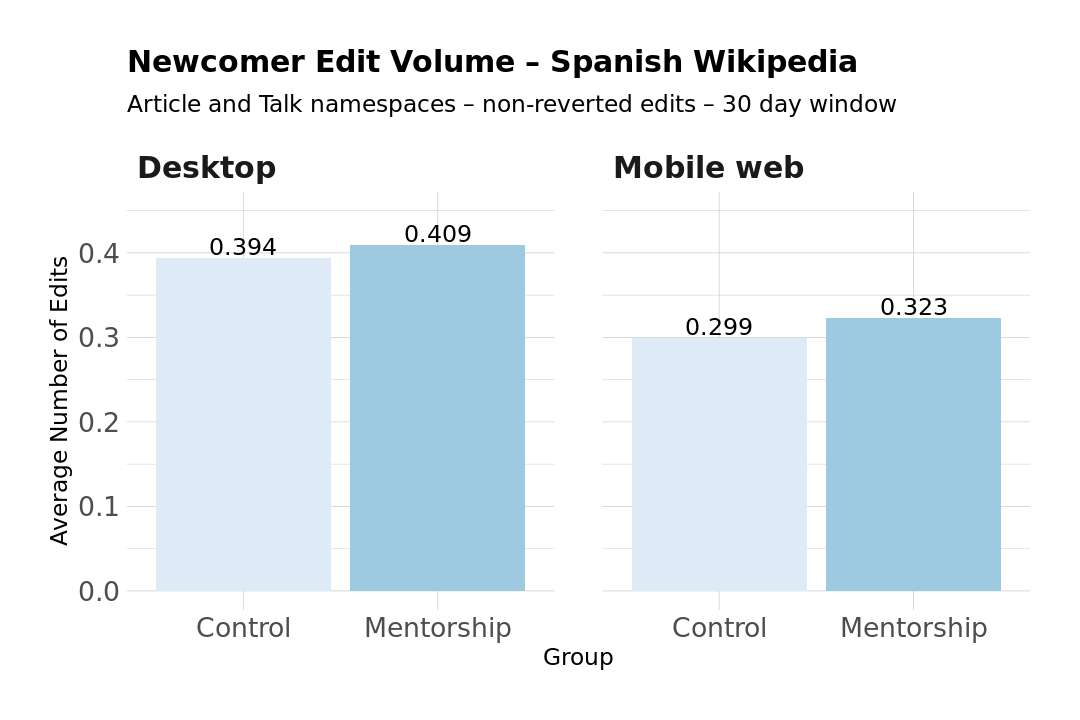

In [21]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
editing_data |>
    filter(
        date(user_registration_ts) > as.Date('2023-05-25')
    ) |>
    mutate(
        platform_name = ifelse(platform == 'mobile', 'Mobile web', 'Desktop'),
        mentorship = ifelse(has_mentor == 'Yes', 'Mentorship', 'Control')
    ) |>
    group_by(platform_name, mentorship) |>
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1, .groups = 'keep') |>
    ggplot(aes(x = mentorship, y = geo_mean, fill = mentorship)) +
        labs(
            title = 'Newcomer Edit Volume – Spanish Wikipedia',
            subtitle = 'Article and Talk namespaces – non-reverted edits – 30 day window',
            x = 'Group',
            y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.45)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.014, size = 5) +
        facet_grid(. ~ platform_name)
ggsave(
     'personalised-praise-experiment-eswiki-constructive-article-edits.png',
    path = 'graphs', bg = 'white',
    width = 9, height = 6, units = "in", dpi = "print")